### imports and setup

In [6]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [7]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import matplotlib.pyplot as plt


In [10]:
# import packages
import numpy as np
import tensorflow as tf

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, make_train_GCN3, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

AttributeError: module 'dateutil' has no attribute 'parser'

In [ ]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


2023-02-20 08:41:40.987523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### check data

#### predict from X1 & X2 input window

In [ ]:
# only uncomment each line if testing a non-default parameter
dataset_x1x2window = lorenzDataset(
    predict_from="X1X2_window",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [ ]:
train_x1x2window = dataset_x1x2window[:int(0.8 * dataset_x1x2window.n_graphs)]
val_x1x2window = dataset_x1x2window[int(0.8 * dataset_x1x2window.n_graphs):]

In [ ]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train_x1x2window.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train_x1x2window.normalize(X1_mean, X1_std, X2_mean, X2_std)
val_x1x2window.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.002458
time to get std&mean from X1: 0:00:00.005539
time to get std&mean from X2: 0:00:00.002745
time to get means: 0:00:00.012294
time to normalize data: 0:00:00.018852


In [ ]:
print(type(train_x1x2window))
train_x1x2window.get_config()

<class 'lorenz.lorenzDataset'>


{'predict_from': 'X1X2_window',
 'n_samples': 100,
 'input_steps': 200,
 'output_steps': 1,
 'output_delay': 100,
 'min_buffer': -300,
 'rand_buffer': False,
 'K': 36,
 'F': 8,
 'c': 10,
 'b': 10,
 'h': 1,
 'coupled': True,
 'time_resolution': 100,
 'seed': 42}

inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

plotting train
plotting val
no training data to plot
editing legend


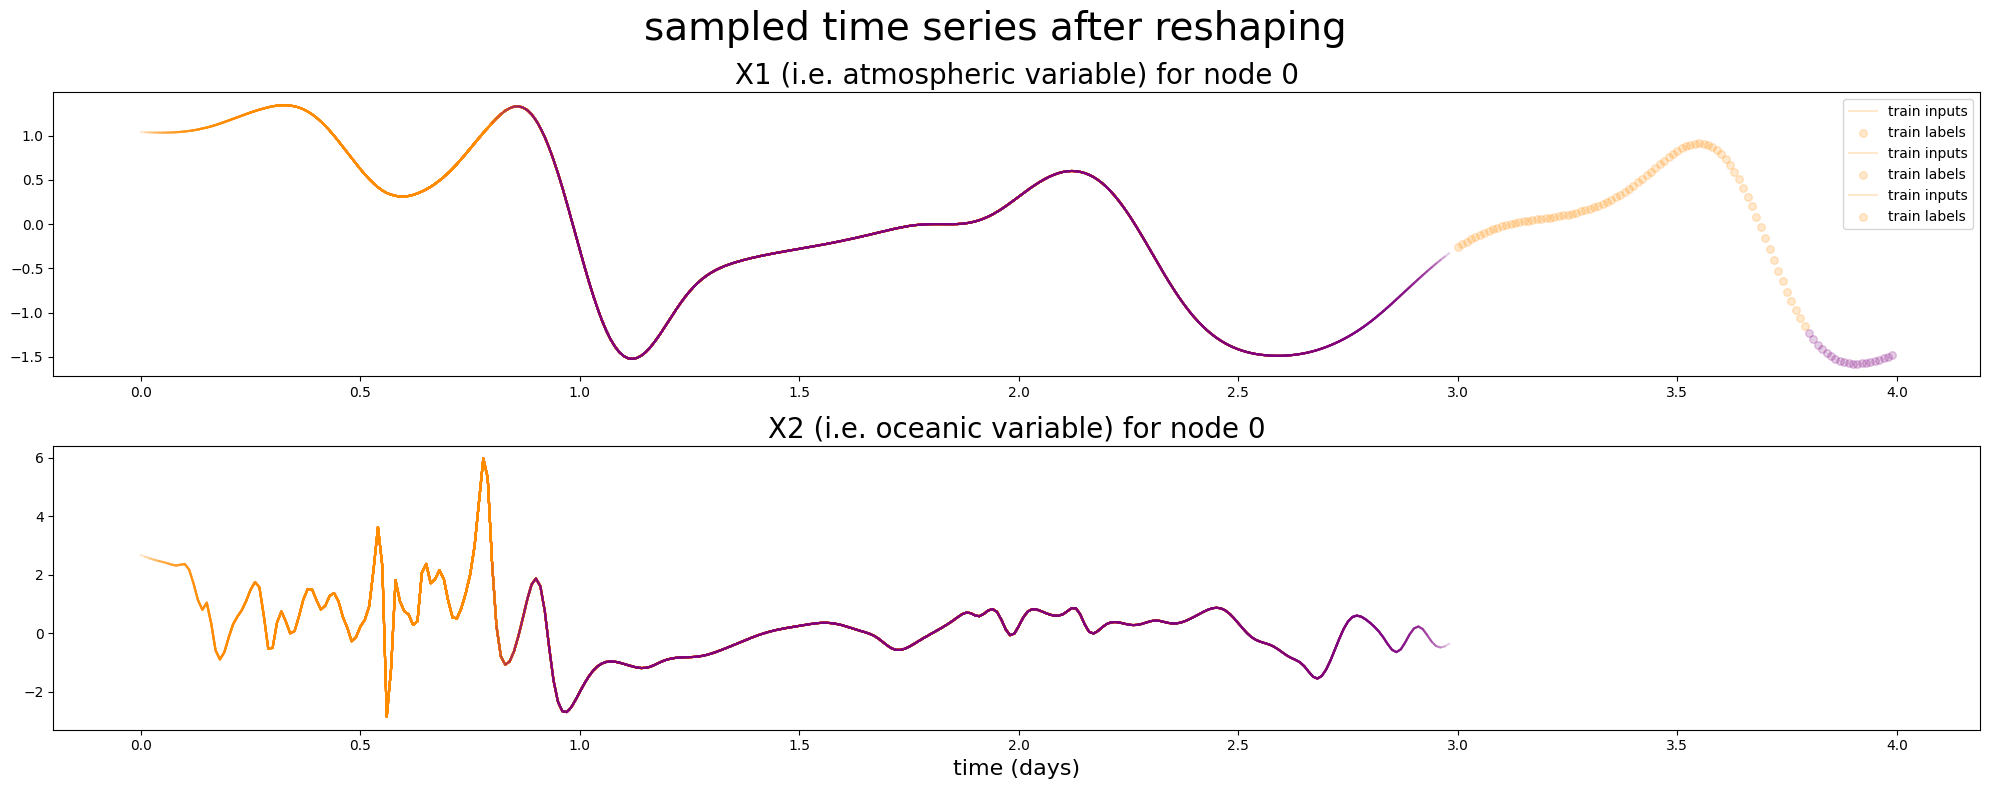

In [ ]:
fig, (ax0, ax1) = plot_data(train_x1x2window, val_x1x2window, test=None, node=0)

plt.tight_layout()
plt.show()

#### predict from X2 (single value)

In [ ]:
# only uncomment each line if testing a non-default parameter
dataset_x2single = lorenzDataset(
    predict_from="X2",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [ ]:
train_x2single = dataset_x2single[:int(0.8 * dataset_x2single.n_graphs)]
val_x2single = dataset_x2single[int(0.8 * dataset_x2single.n_graphs):]

In [ ]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train_x2single.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train_x2single.normalize(X1_mean, X1_std, X2_mean, X2_std)
val_x2single.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.002458
time to get std&mean from X1: 0:00:00.005539
time to get std&mean from X2: 0:00:00.002745
time to get means: 0:00:00.012294
time to normalize data: 0:00:00.018852


In [ ]:
print(type(train_x2single))
train_x2single.get_config()

<class 'lorenz.lorenzDataset'>


{'predict_from': 'X1X2_window',
 'n_samples': 100,
 'input_steps': 200,
 'output_steps': 1,
 'output_delay': 100,
 'min_buffer': -300,
 'rand_buffer': False,
 'K': 36,
 'F': 8,
 'c': 10,
 'b': 10,
 'h': 1,
 'coupled': True,
 'time_resolution': 100,
 'seed': 42}

inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

plotting train
plotting val
no training data to plot
editing legend


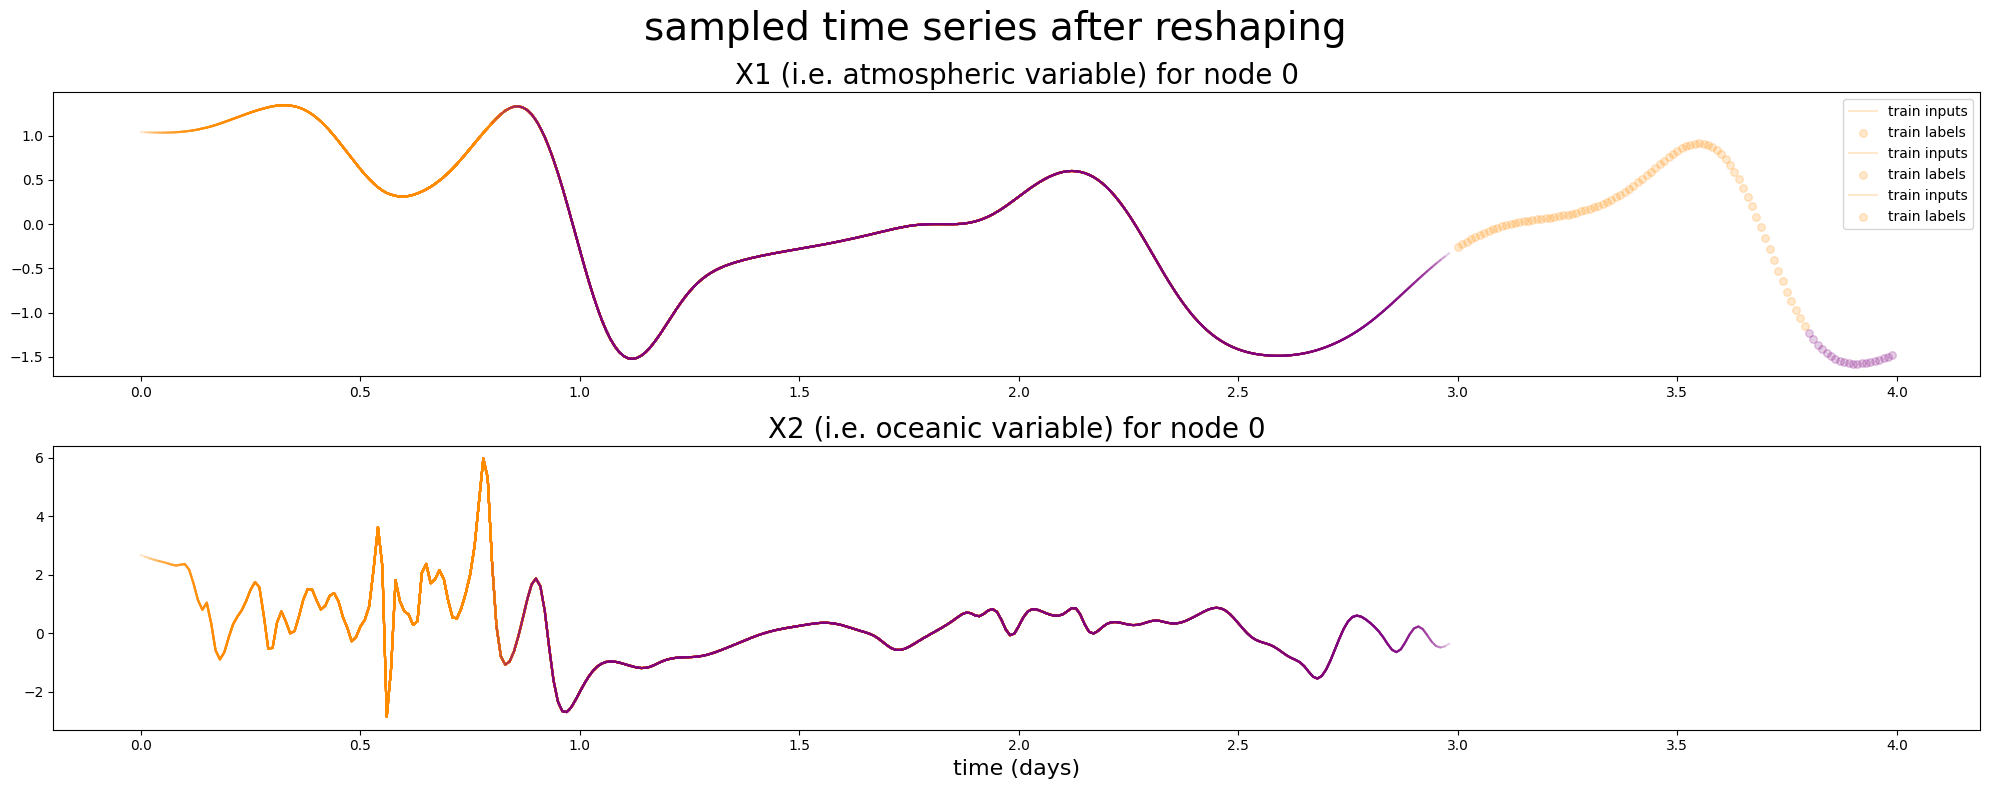

In [ ]:
fig, (ax0, ax1) = plot_data(train_x2single, val_x2single, test=None, node=0)

plt.tight_layout()
plt.show()

#### predict from X2 input window

In [ ]:
# TODO: update plotting code

## sandbox

### 2-layer GCN

In [9]:
model, history, fname = make_train_GCN3(train,
                                        val,
                                        activation="relu",
                                        epochs=30,
                                        eval_val=True,
                                        early_stopping=True,
                                        early_stopping_patience=5,
                                        early_stopping_start_from_epoch=10,
                                        tensorboard=True)


Epoch 1/100
219/219 [==============================] - 18s 74ms/step - loss: 36.1343 - val_loss: 1.1918
Epoch 2/100
 45/219 [=====>........................] - ETA: 11s - loss: 1.1531

32/32 [==============================] - 1s 23ms/step


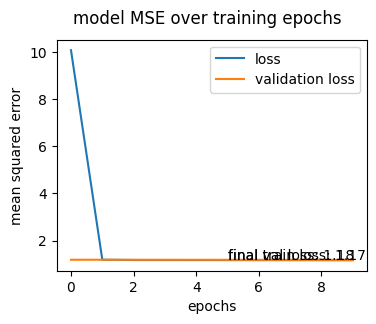

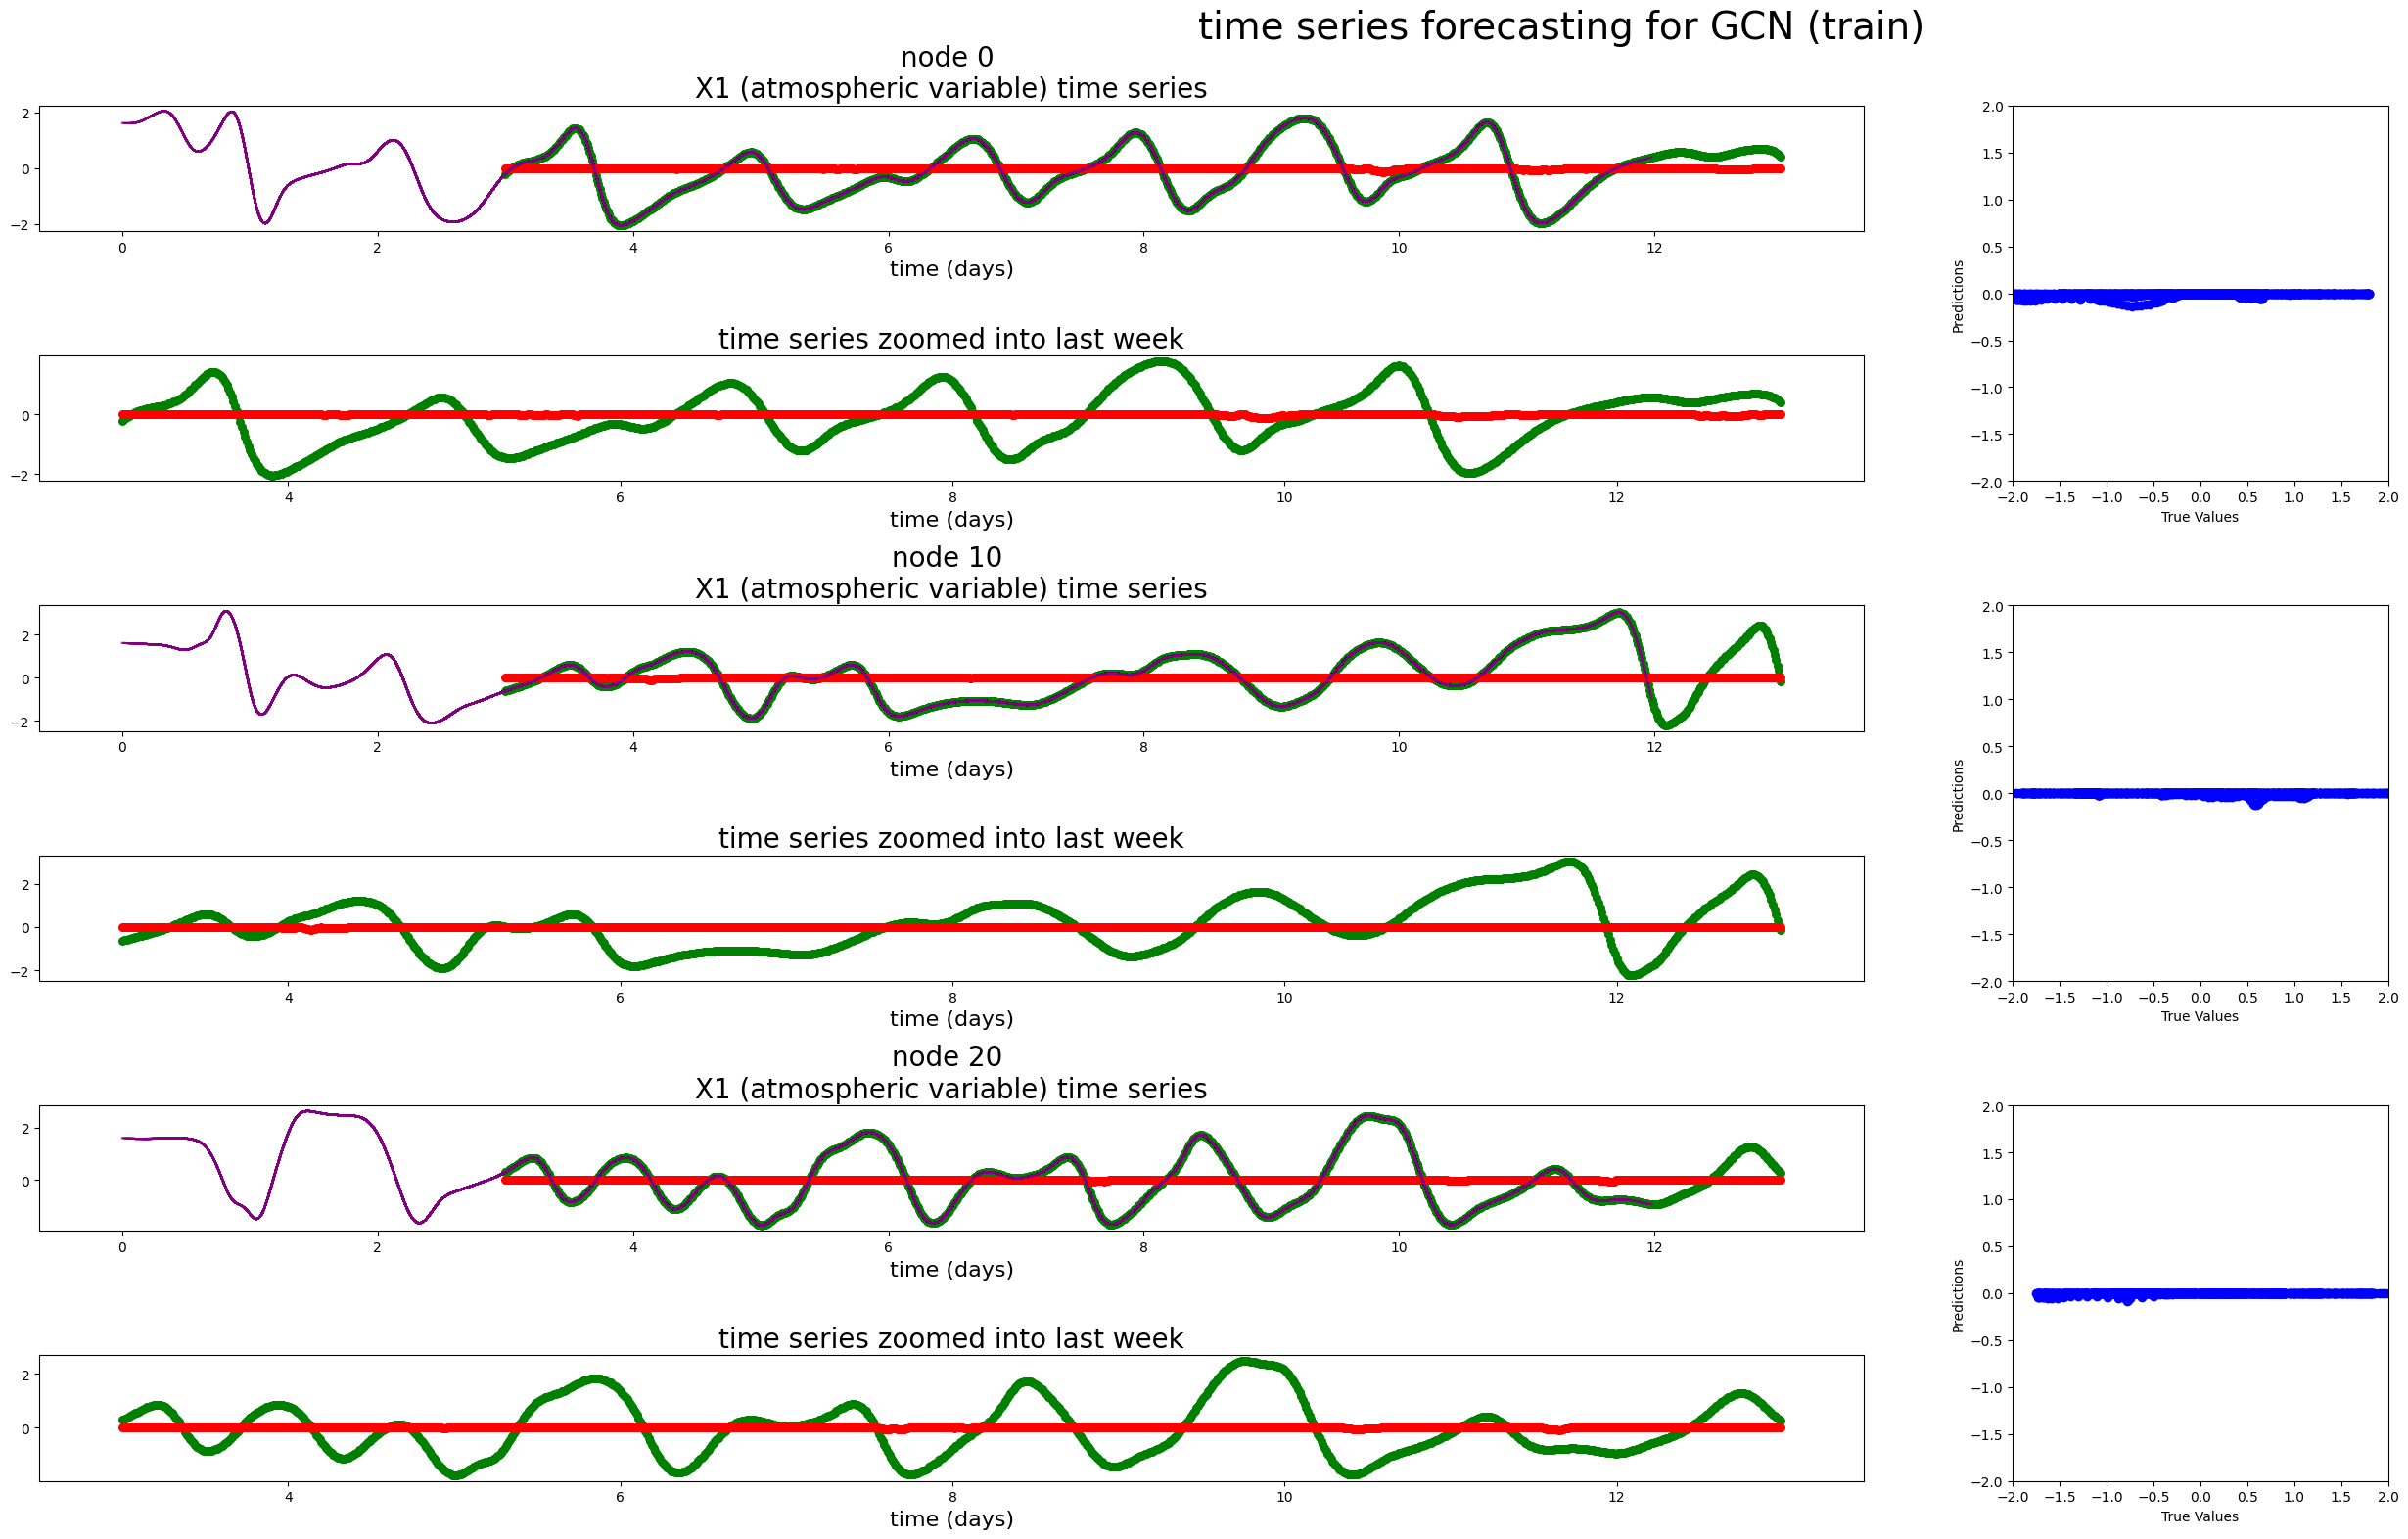

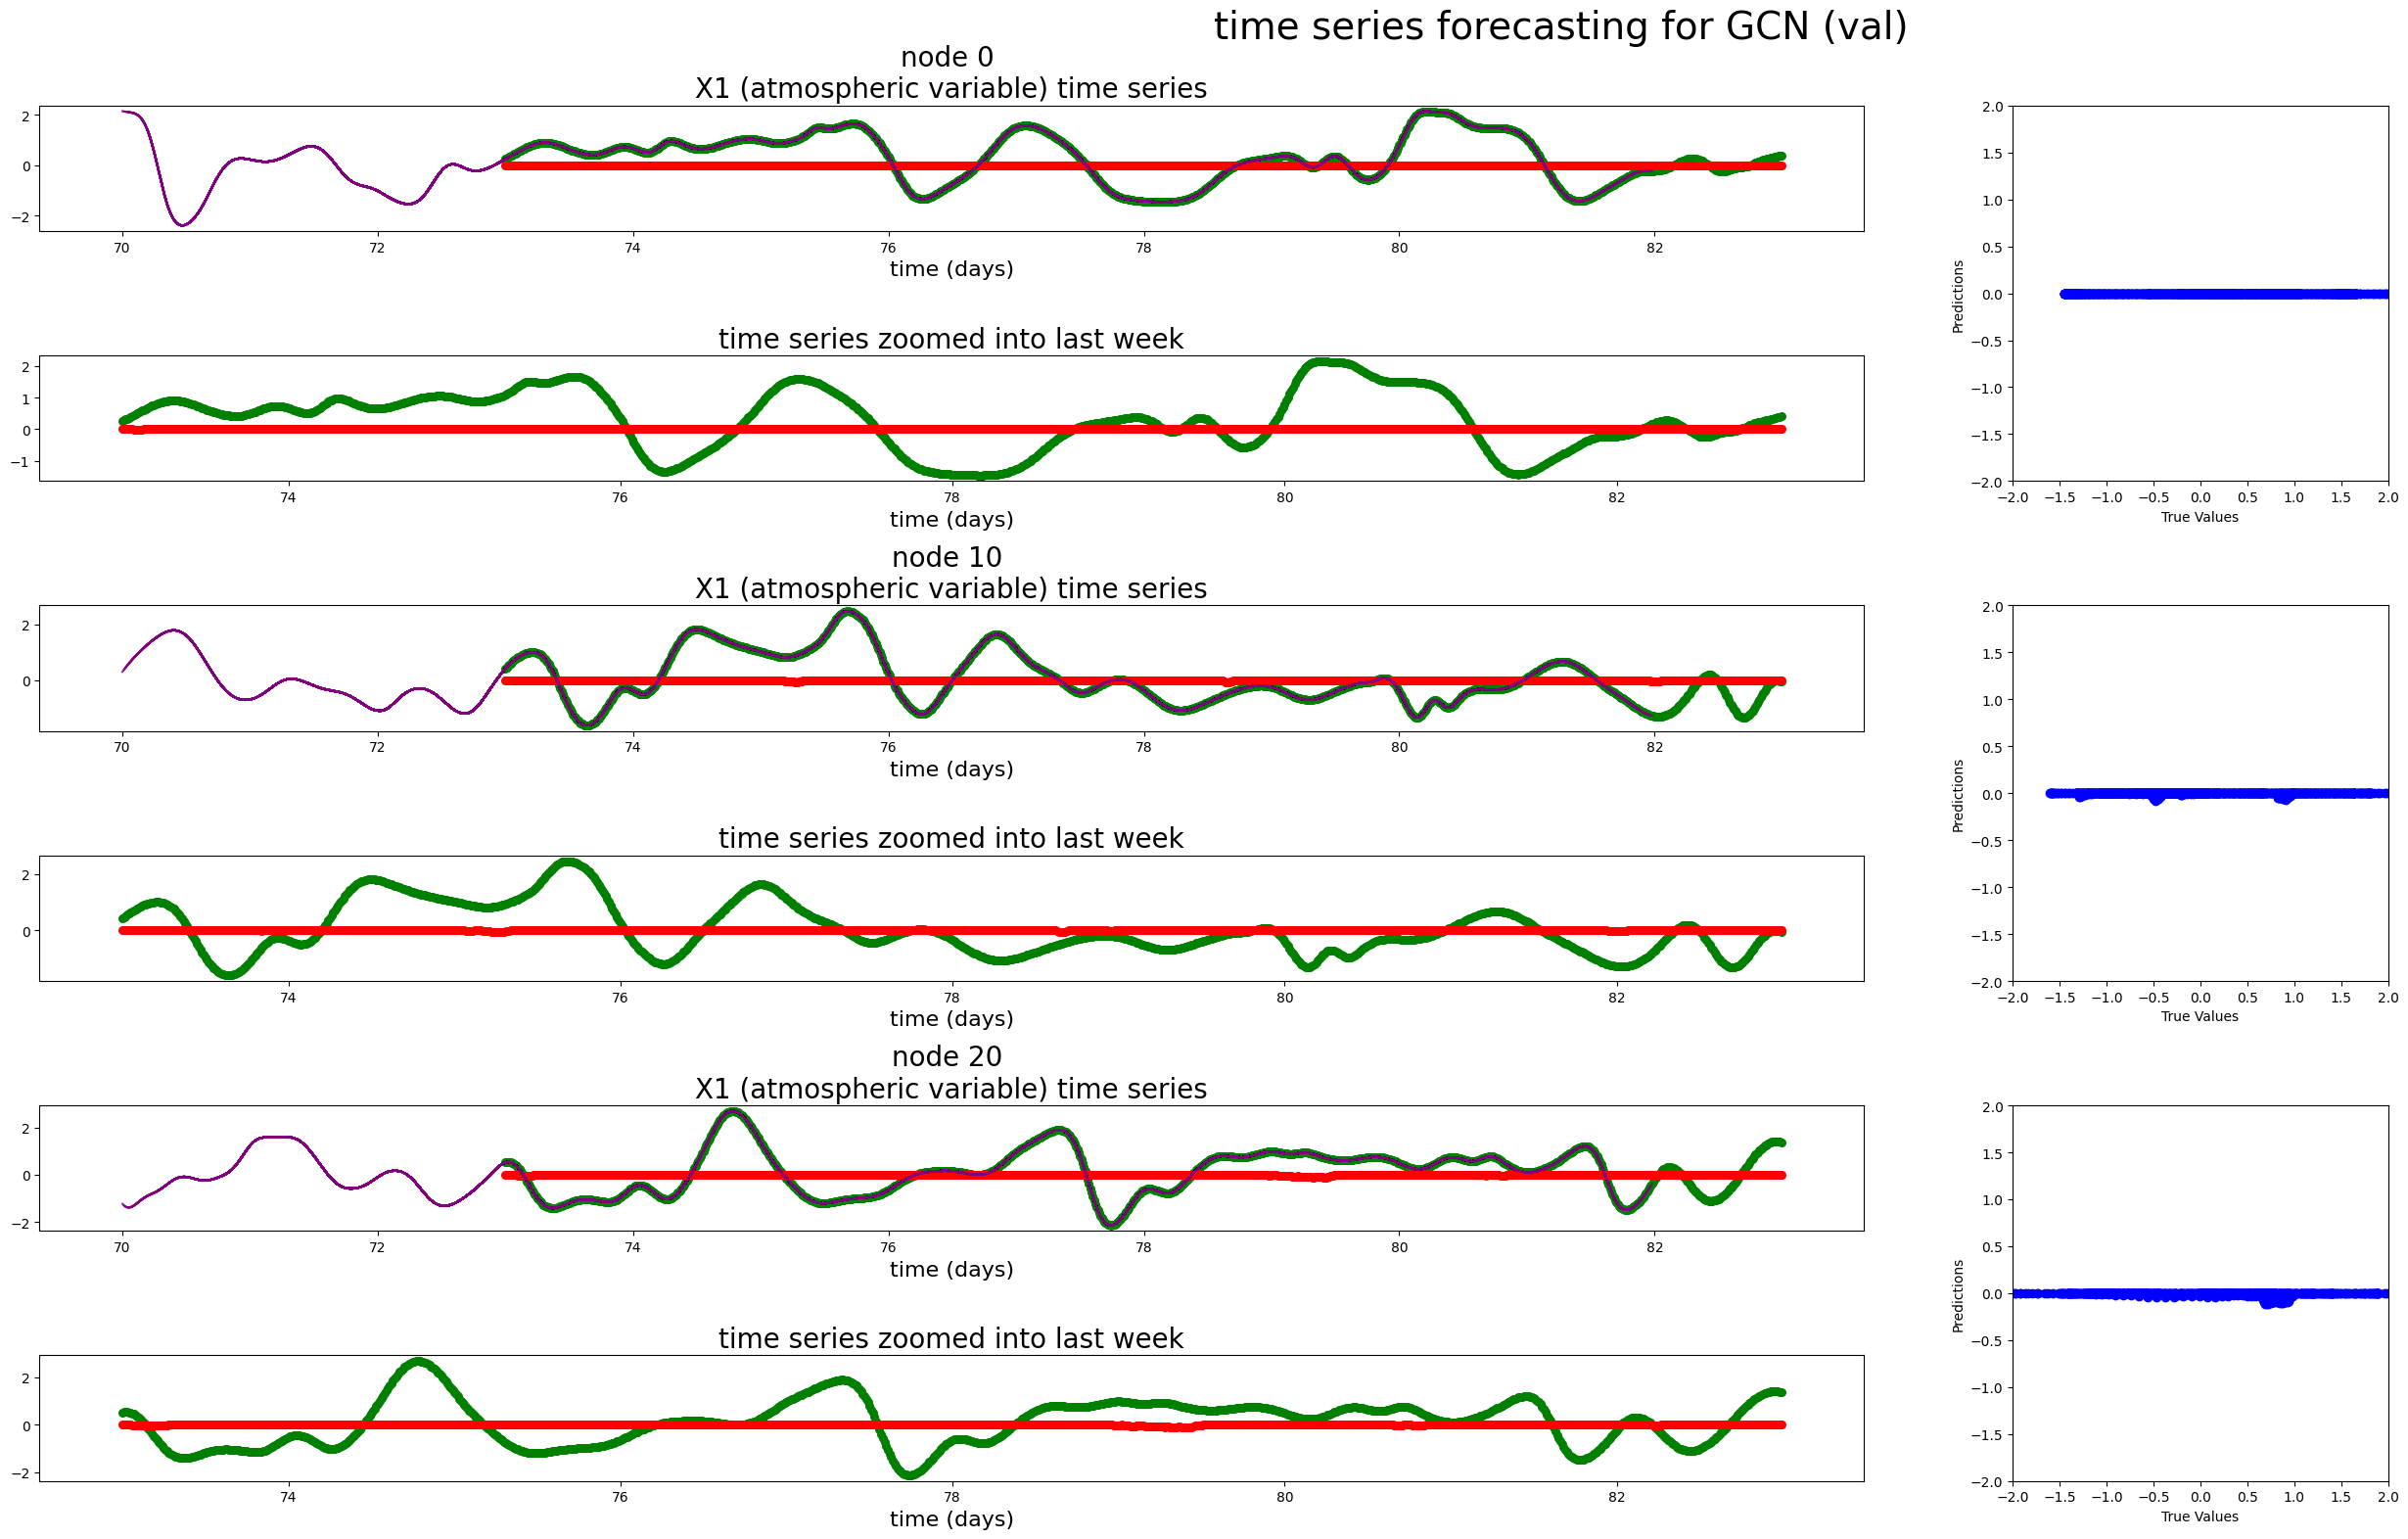

In [ ]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], model, history, epochs=5)